In [1]:
import os

import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from cnpe_validation.tasks.eight_schools import EightSchoolsTask
from cnpe_validation.tasks.tasks import AbstractTaskWithReference
from cnpe_validation.tasks.two_moons import TwoMoonsTask
from cnpe_validation.tasks.sirsde import SIRSDETask

from cnpe_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())

In [10]:
results = []

tasks = {
    "two moons": TwoMoonsTask,
    "eight schools": EightSchoolsTask,
    "sirsde": SIRSDETask,
}

task = tasks["eight schools"]

files = [f for f in os.listdir(f"results/{task.name}") if "true_posterior_log_probs" in f]
num_results = len(files)
for file in files:
    results.append(np.load(f"results/{task.name}/{file}"))

In [11]:
results = {k: np.stack([res[k] for res in results]) for k in results[0].keys()}

In [12]:
if issubclass(task, AbstractTaskWithReference): # We just subsample results for now
    keys = jr.split(jr.PRNGKey(0), len(results))
    num_samples = 2000
    results = {
        name: jr.choice(jr_key, val.ravel(), (num_samples, ), replace=False)
        for jr_key, (name, val) in zip(keys, results.items(), strict=True)
        }

Text(105.47222222222221, 0.5, 'Probability $\\mathbb{\\theta}^*$ for 101 runs')

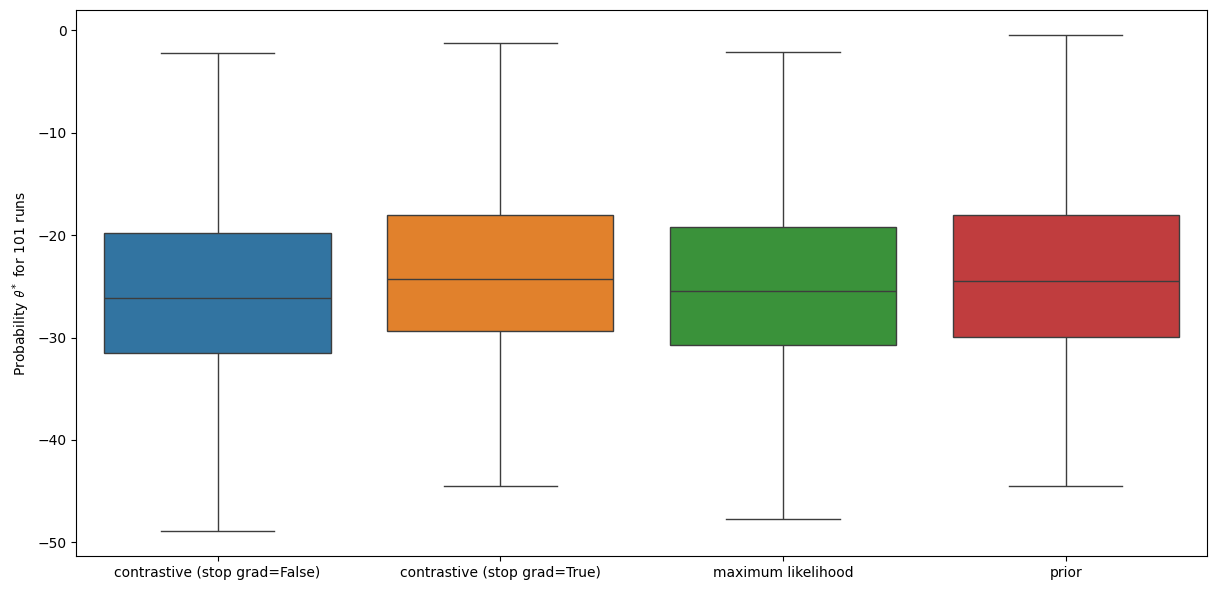

In [13]:
plt.figure(figsize=(12,6)) # this creates a figure 8 inch wide, 4 inch high
sns.boxplot(pd.DataFrame(results), showfliers="")
plt.tight_layout()
plt.ylabel(fr"Probability $\mathbb{{\theta}}^*$ for {num_results} runs")

In [14]:
import os

import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from cnpe_validation.tasks.eight_schools import EightSchoolsTask
from cnpe_validation.tasks.tasks import AbstractTaskWithReference
from cnpe_validation.tasks.two_moons import TwoMoonsTask
from cnpe_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())

maximum likelihood
contrastive (stop grad=False)
contrastive (stop grad=True)


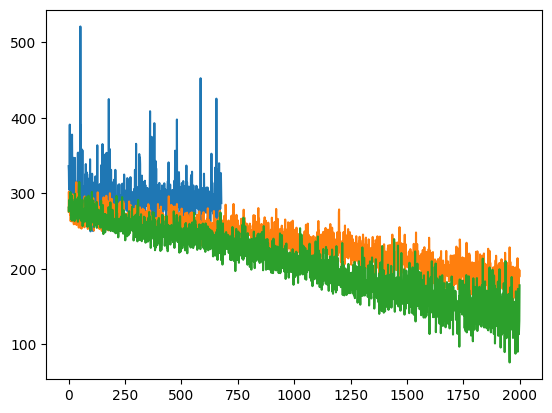

In [26]:
losses = np.load("results/sirsde/losses_0.npz")

for k, v in losses.items():
    print(k)
    plt.plot(v.item(), label=k)

In [32]:
losses = np.load("results/sirsde/true_posterior_log_probs_0.npz")

print({k: v for k, v in losses.items()})

{'maximum likelihood': array(-60.097004, dtype=float32), 'contrastive (stop grad=False)': array(9.746138, dtype=float32), 'contrastive (stop grad=True)': array(-217.52704, dtype=float32), 'prior': array(-58.39159, dtype=float32)}
